In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import abc
from torch.distributions import MultivariateNormal, Poisson
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
from torch import nn
from torch.optim.lr_scheduler import StepLR
from main import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import pickle
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score
import dill

In [2]:
# m = dill.load(open('synthetic_rec.pkl', 'rb'))
# model = m.gen_model
# def get_rec_model(m):
#     gen = LDS(z = m.gen_model.z, Y = m.gen_model.Y, lik = m.gen_model.lik, x_dim=m.gen_model.x_dim, link_fn=m.gen_model.link_fn, A=m.gen_model.A, C=m.gen_model.C, W=m.gen_model.W, B=m.gen_model.B, mu0=m.gen_model.mu0, Sigma0_half=m.gen_model.Sigma0_half, sigma_x=m.gen_model.sigma_x,
#                  trained_z=False, d=m.gen_model.d, fixed_d=True, single_sigma_x=False, full_R=False)
#     gen.freeze_params()
#     rec_model = RecognitionModel(gen, neural_net=m.neural_net, cov_change=False)
#     rec_model.freeze_params()
#     return rec_model, gen
# model = get_rec_model(m)[1]

[[ 0.2782208   0.20921635 -0.15783327 -0.11597944  0.50267757]
 [ 0.20921635  0.62540461 -0.07440552 -0.1590074  -0.34949867]
 [-0.15783327 -0.07440552  0.56790749 -0.23986521 -0.04603175]
 [-0.11597944 -0.1590074  -0.23986521  0.53484125  0.11551827]
 [ 0.50267757 -0.34949867 -0.04603175  0.11551827 -0.10637415]]
(5,) (5, 5)


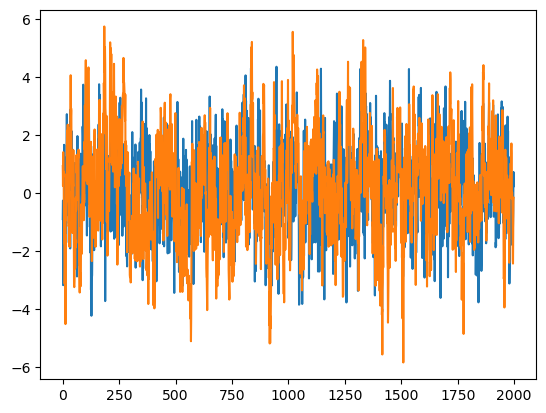

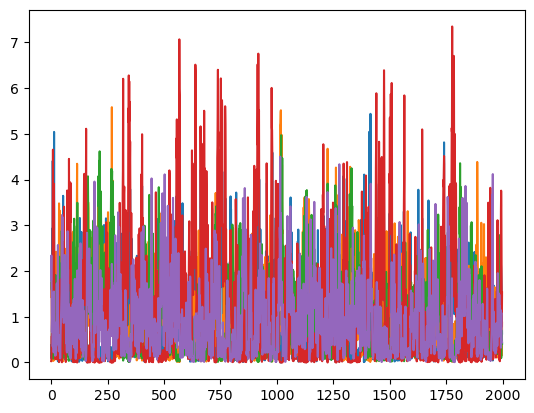

0.9186241456379446


In [3]:
# Simulate some data
torch.manual_seed(0)
np.random.seed(0)
N = 100
z_dim = 5
# x_dim = 5
x_dim = 100

# sqrt m  division in matrix C 

# A = np.array([[0.9, 0.4], [-0.2, 0.8]])
# s = np.array([0.8, 0.99]).reshape(1, -1)
# u, _ = np.linalg.qr(np.random.randn(s.shape[1], s.shape[1]))
# A = u @ np.diag(s.squeeze()) @ u.T
eigs = np.array([-0.6, 0.2, 0.6, 0.8, 0.9])
A = np.diag(eigs)
u, _ = np.linalg.qr(np.random.randn(z_dim, z_dim))
A = u @ A @ u.T
print(A)

# B = np.array([[0.1, 0.0], [0.0, 0.1]])
B = 1 * np.eye(z_dim)
# W = np.eye(x_dim)
W = np.random.randn(x_dim, z_dim) / np.sqrt(z_dim)




# C = np.random.randn(N, x_dim) / np.sqrt(x_dim)
C = np.eye(N)

sigma_x = 0.1

# mu0 = np.array([0., 0.])
# Sigma0 = np.array([[.010, 0.0], [0.0, .010]])
mu0 = np.zeros(z_dim)
Sigma0 = 1 * np.eye(z_dim)
print(mu0.shape, Sigma0.shape)

ntrials = 1
# v0 = np.random.multivariate_normal(mu0, Sigma0)
v0 = mu0 + (np.linalg.cholesky(Sigma0) @ np.random.randn(ntrials,z_dim, 1)).squeeze(-1)

T = 2000
v = np.zeros((ntrials,z_dim,T))
x = np.zeros((ntrials,x_dim,T))
x_noise_free = np.zeros((ntrials,x_dim,T))
v[:,:, 0] = v0
x_noise_free[:,:, 0] = (W @ v0[..., None]).squeeze(-1)
x[:,:, 0] = (W @ v0[..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim,)
for t in range(1, T):
    v[..., t] = (A @ v[..., t-1][..., None]).squeeze(-1) + (B @ np.random.randn(ntrials, z_dim,1)).squeeze(-1)
    x_noise_free[..., t] = (W @ v[..., t][..., None]).squeeze(-1)
    x[..., t] = (W @ v[..., t][..., None]).squeeze(-1) + sigma_x * np.random.randn(ntrials, x_dim)

stop = -1
plt.plot(v[-1,0,:stop])
plt.plot(v[-1,1,:stop])
plt.show()

# _d = 0.5
_d = 0
F = C[None, ...] @ x + _d
# plt.plot(F[0,0,:stop])
# plt.plot(F[0,1,:stop])

# link = np.exp
link = lambda x: 1 * np.log(1 + np.exp(x))
dt = 1
for i in range(5):
    plt.plot(link(F[0,i,:stop])*dt)
plt.show()

# Average firing rate
print(np.mean(link(F)))


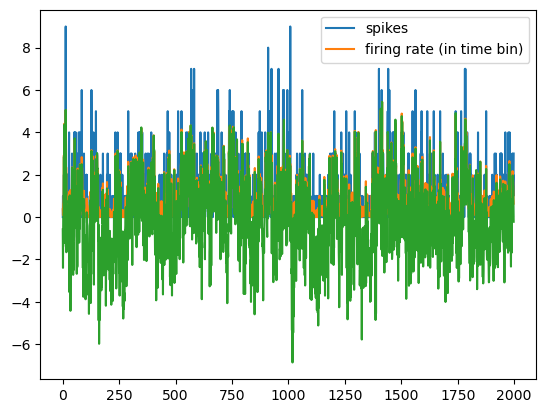

In [4]:
# link_fn = torch.exp
# link = lambda x: np.exp(x)
link_fn = lambda x: 1 * torch.nn.functional.softplus(x)
link = lambda x: 1 * np.log(1 + np.exp(x))
lik = Poisson_noise()
Y = np.random.poisson(link(F)*dt)

train_len = 1000
Y_train = Y[..., :train_len]
v_train = v[..., :train_len]
Y_test = Y[..., train_len:]
v_test = v[..., train_len:]


# sigma = 0.1
# Y = np.random.randn(*F.shape) * sigma + F
# lik = Gaussian_noise(sigma)
# link_fn = lambda x: x

# # Sigmoid link function
# link = lambda x: 1 / (1 + np.exp(-x))
# Y = np.random.negative_binomial(link(F), 0.5)
# lik = Negative_binomial_noise(Tensor(Y))
# link_fn = lambda x:x

plt.plot(Y[0,0,:stop], label='spikes')
# plt.plot(Y[0,1,:stop])
plt.plot(link(F[0,0,:stop])*dt, label='firing rate (in time bin)')
plt.plot(x_noise_free[0,0,:stop])
plt.legend()
plt.show()


# # model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, d=_d, C=Tensor(C).to(device))
# # model.C.requires_grad = False

# model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, fixed_d=False, d=_d)

# train_params = {'batch_size': None, 'n_mc': 500, 'step_size': 500, 'lrate': 1e-2, 'max_steps': 1001, 'gamma': 0.85, 'StepLR': True}
# np.random.seed(0)
# torch.manual_seed(0)
# model.train_supervised_model(model.training_params(**train_params))
# model.plot_LL()

# Fixed generative model
model = LDS(Tensor(v_train), Tensor(Y_train), lik, x_dim=x_dim, link_fn=link_fn, 
            A=Tensor(A[None, ...]).to(device), B=Tensor(B[None, ...]).to(device), W=Tensor(W[None,...]).to(device), C=Tensor(C[None, ...]).to(device),
            mu0=Tensor(mu0[None, ...]).to(device), Sigma0_half=Tensor(np.linalg.cholesky(Sigma0)[None, ...]).to(device),
            sigma_x=(torch.ones(x_dim) * sigma_x).to(device), d=_d)

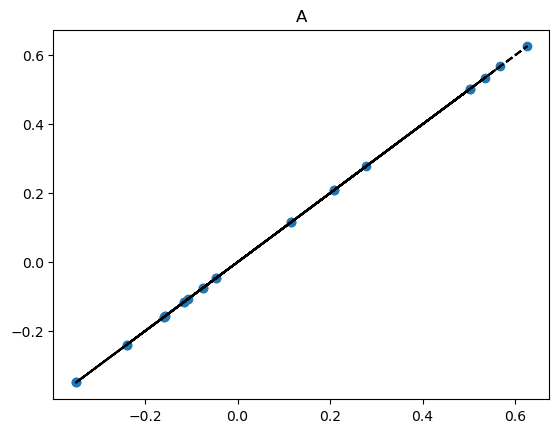

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] 0


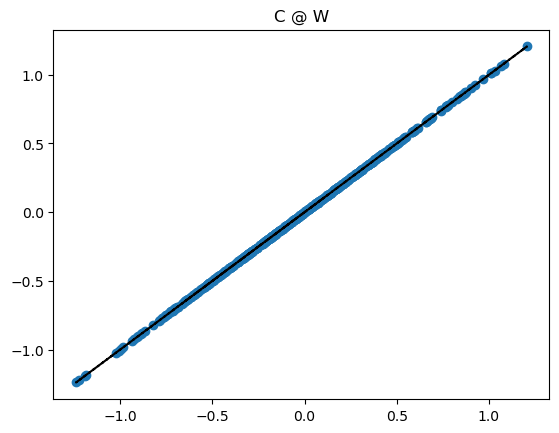

[[[ 1.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.]
  [ 0.  0.  0.  1.  0.]
  [ 0.  0.  0. -0.  1.]]] [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0. -0.  1.]]
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.

In [5]:
# for name, prm in model.named_parameters():
#     if name in ['C', 'W']:
#         continue
#     print(f'Name: {name} - Shape: {prm.shape} - Parameter: {prm}')


# # print(C @ W )
# # print(model.C @ model.W)
# print((C@W - (model.C @ model.W).detach().cpu().numpy()))
# # print(C @ W)
# print(model.Sigma0)

plt.plot(model.A.detach().cpu().numpy().flatten(), A.flatten(), 'o')
# plot y = x line 
plt.plot(A.flatten(), A.flatten(), 'k--')
plt.title('A')
plt.show()

print(model.d.detach().cpu().numpy(), _d)

plt.plot((model.C @ model.W).detach().cpu().numpy().flatten(), (C @ W).flatten(), 'o')
# plot y = x line
plt.plot((C @ W).flatten(), (C @ W).flatten(), 'k--')
plt.title('C @ W')
plt.show()

print(model.Sigma0_half.detach().cpu().numpy(), np.linalg.cholesky(Sigma0))

print(model.sigma_x, sigma_x)

print(model.mu0.detach().cpu().numpy(), mu0)

print(model.B, B)


torch.Size([1, 1, 5, 1000])


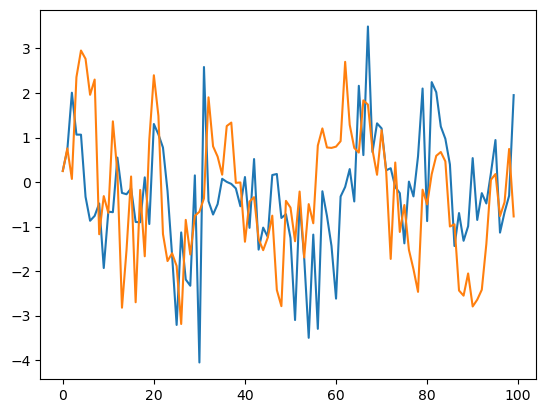

In [6]:
model.freeze_params()
z_samps = model.sample_z(1, trials=1)
print(z_samps.shape)
stop = 100
for i in range(len(z_samps)):
    plt.plot(z_samps[i,0,0, :stop].detach().cpu().numpy())
    plt.plot(z_samps[i,0,1, :stop].detach().cpu().numpy())
    plt.show()

In [6]:
# Load saved neural network
# state_dict = torch.load('my_sequential_model.pth')

100
step 0 LL -1.5358978125 Entropy -0.138890849609375 Joint LL -1.39700703125 Gamma 1.0
step 1 LL -1.52488234375 Entropy -0.138890849609375 Joint LL -1.3859915625 Gamma 1.0
step 2 LL -1.516273046875 Entropy -0.138890849609375 Joint LL -1.377382265625 Gamma 1.0
step 3 LL -1.5022759375 Entropy -0.138890849609375 Joint LL -1.36338515625 Gamma 1.0
step 4 LL -1.49228984375 Entropy -0.138890849609375 Joint LL -1.3533990625 Gamma 1.0
step 5 LL -1.480559375 Entropy -0.138890849609375 Joint LL -1.34166859375 Gamma 1.0
step 6 LL -1.4712121875 Entropy -0.138890849609375 Joint LL -1.33232140625 Gamma 1.0
step 7 LL -1.46014828125 Entropy -0.138890849609375 Joint LL -1.3212575 Gamma 1.0
step 8 LL -1.449692734375 Entropy -0.138890849609375 Joint LL -1.310801953125 Gamma 1.0
step 9 LL -1.439952109375 Entropy -0.138890849609375 Joint LL -1.30106125 Gamma 1.0
step 10 LL -1.43066328125 Entropy -0.138890849609375 Joint LL -1.2917725 Gamma 1.0
step 11 LL -1.424348203125 Entropy -0.138890849609375 Joint LL

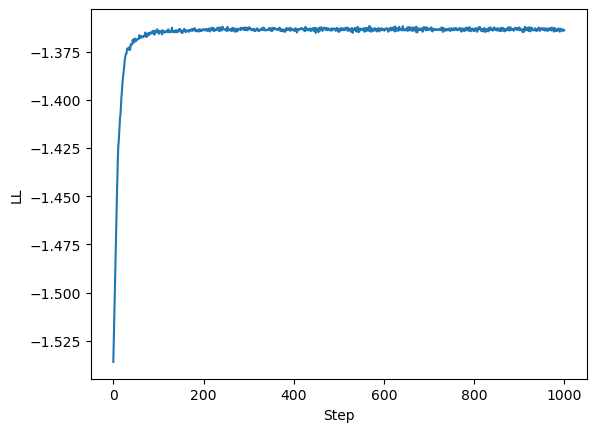

In [13]:

model.freeze_params()
print(model.x_dim)

torch.manual_seed(0)
np.random.seed(0)

class MyRNNModel(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        self.fc = torch.nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

neural_net = MyRNNModel(model.N, 100, model.x_dim)

# # # Substituting the true parameters
# # neural_net = torch.nn.Sequential(
# #                 torch.nn.Linear(model.N, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 torch.nn.Linear(100, 100),
# #                 torch.nn.ReLU(),
# #                 # torch.nn.Linear(100, 100),
# #                 # torch.nn.ReLU(),
# #                 torch.nn.Linear(100, model.x_dim)
# #             )
# # # neural_net.load_state_dict(state_dict)
# # # rec_model = RecognitionModel(model, neural_net=neural_net)

# class RNNModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNNModel, self).__init__()
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True) # needs ntrials, T, N
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out)
#         return out

# neural_net = RNNModel(model.N, 100, model.x_dim)

# neural_net.load_state_dict(state_dict)
rec_model = RecognitionModel(model, neural_net=neural_net, zero_mean_x_tilde=True, cov_change=False)


# # Try changing cov
# torch.autograd.set_detect_anomaly(True)
# neural_net = RNNModel(model.N, 100, model.x_dim+1)
# rec_model = RecognitionModel(model, neural_net=neural_net, cov_change=True)

train_params = {'batch_size': None, 'step_size': 1000, 'lrate': 1e-3, 'max_steps': 1001, 'n_mc_x': 50, 'n_mc_z': 50, 'batch_mc_z': 25}
rec_model.train_recognition_model(rec_model.training_params(**train_params))
rec_model.plot_LL()

torch.Size([1, 100, 1000])


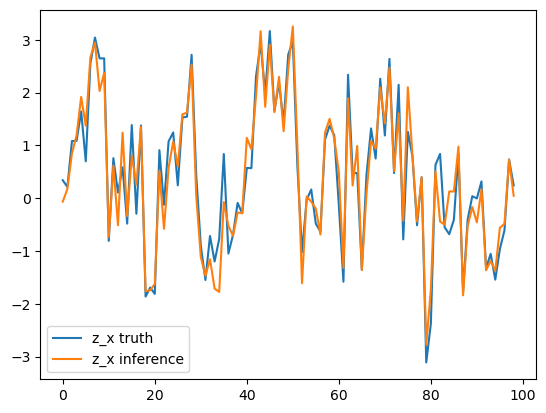

0.8919806206050515 z_0
0.9136654319926579 z_1
0.9132102631002468 z_2
0.9071449429027277 z_3
0.8915861122908652 z_4
(1, 100, 2000)


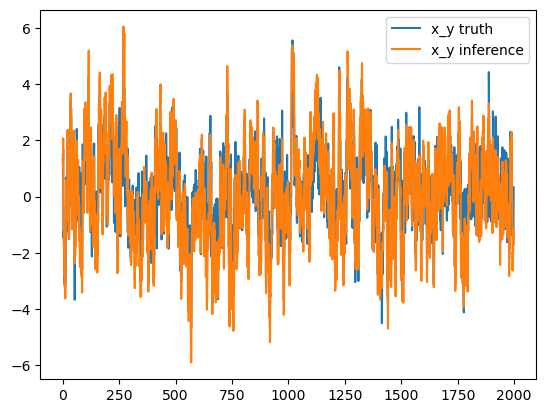

0.886616714705552 x_0
0.690659307208493 x_1
0.7978668954526503 x_2
0.7955145863961167 x_3
0.8658419843154628 x_4
0.49646925907033834 x_5
-0.1102949925502903 x_6
0.347244442801646 x_7
0.8621327999308703 x_8
0.8874723030130981 x_9
0.457213287352241 x_10
0.895635315651752 x_11
0.846283049175241 x_12
0.7335665855595999 x_13
0.5251090014066339 x_14
0.8229868847314383 x_15
0.8855493730740078 x_16
0.8969422990806495 x_17
0.3905865712736183 x_18
0.7873025444181762 x_19
0.45065372159823325 x_20
-0.03443914435957107 x_21
0.5403027737652308 x_22
0.8829923916680047 x_23
0.8275723028309604 x_24
0.8963968126906352 x_25
0.8697697753062102 x_26
0.8757132403261183 x_27
0.9101455612336238 x_28
0.8227325051089341 x_29
0.19026184960066062 x_30
0.7404275672006251 x_31
0.8883089900106547 x_32
0.6868570144774666 x_33
0.8568501575963211 x_34
0.09029331753478975 x_35
0.5791723216514326 x_36
0.8639671814685883 x_37
0.8716413865569024 x_38
0.6866283524920891 x_39
-1.7443092643864957 x_40
0.7834101903051152 x_41


In [17]:
print(rec_model.gen_model.Y.shape)
z = rec_model.test_z(Tensor(Y).to(device))
z = z.detach().cpu().numpy()

start = -100
stop = -1
plt.plot(v[0,0,start:stop], label = 'z_x truth')
# plt.plot(v[0,1,:100], label = 'z_y truth')
plt.plot(z[0,0,start:stop], label = 'z_x inference')
# plt.plot(z[0,1,:100], label = 'z_y inference')
plt.legend()
plt.show()

# for i in range(5):
#     plt.plot(z[0,i,:stop], label = 'z_x inference')
# plt.show()
# for i in range(5):
#     plt.plot(v[0,i,:stop], label = 'z_x truth')   
#     # plt.legend()
# plt.show()

# print R^2 for x and y decoding using sklearn
# print(r2_score(v[0,1,:], z[0,1,:]))
# print(r2_score(v[0,0,:], z[0,0,:]))
for i in range(rec_model.gen_model.b):
    print(r2_score(v[0,i,train_len:], z[0,i,train_len:]), 'z_{}'.format(i))

x_tilde = rec_model.get_x_tilde(Tensor(Y).to(device)).detach().cpu().numpy()
print(x_tilde.shape)
stop = -1
# plt.plot(x_noise_free[0,0,:stop], label = 'x_x truth')
# plt.plot(x_tilde[0,0,:stop], label = 'x_x inference')
plt.plot(x_noise_free[0,1,:stop], label = 'x_y truth')
plt.plot(x_tilde[0,1,:stop], label = 'x_y inference')
plt.legend()
plt.show()
# print R^2 for x_tilde
for i in range(rec_model.gen_model.x_dim):
    print(r2_score(x_noise_free[0,i,:], x_tilde[0,i,:]), 'x_{}'.format(i))
# print(r2_score(x_noise_free[0,0,:], x_tilde[0,0,:]), 'x_x')
# print(r2_score(x_noise_free[0,1,:], x_tilde[0,1,:]), 'x_y')
# print(r2_score(x_noise_free, x_tilde), 'x_all')

# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
# _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# # _ , mus_smooth, _ = rec_model.kalman_means(Tensor(x[None, ...]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
# mus_smooth = mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0)
# print(mus_smooth.shape)
# stop = 100
# plt.plot(v[0,0,:stop], label = 'z_x truth')
# plt.plot(mus_smooth[0, 0,:stop], label = 'z_x inference')
# plt.plot(v[0,1,:stop], label = 'z_y truth')
# plt.plot(mus_smooth[0, 1,:stop], label = 'z_y inference')
# plt.legend()
# plt.show()

# # print R^2 for x and y smoothing using sklearn
# print(r2_score(v[0,1,:], mus_smooth[0, 1,:]))
# print(r2_score(v[0,0,:], mus_smooth[0, 0,:]))


In [9]:
_A = Tensor(A).to(device)
_W = Tensor(W).to(device)
_Q = Tensor(B @ B.T).to(device)
_R = Tensor(np.eye(N) * sigma_x**2).to(device)
_Sigma0 = Tensor(Sigma0).to(device)
_mu0 = Tensor(mu0).to(device)
gaussian_Y = Tensor(Y - Y.mean(2)[..., None]).to(device)
_, _, Ks, Cs = general_kalman_covariance(A=_A, W=_W, Q=_Q, R=_R, b=z_dim, x_dim=x_dim, Sigma0=_Sigma0, T=2000, get_sigma_tilde=False, smoothing=True)
_, gaussian_mus_smooth, _ = general_kalman_means(A=_A, W=_W, b=z_dim, mu0=_mu0, x_hat=gaussian_Y[None, ...], Ks=Ks, Cs=Cs, smoothing=True)

torch.Size([2000, 1, 1, 5])
0.7840359015975084
0.7870440645095884
0.7965260065831103
0.7885589265264047
0.7882677710919533


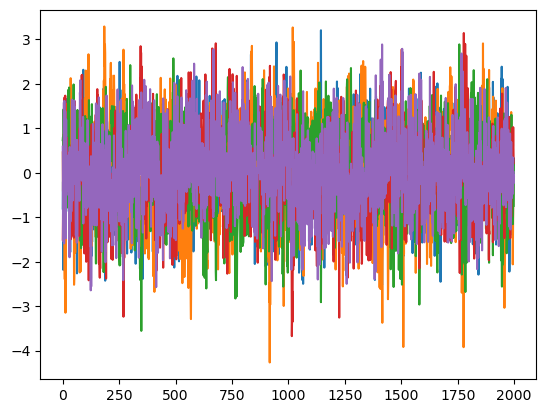

In [10]:
print(gaussian_mus_smooth.shape) # (T, n_mc, ntrials, b)
gaussian_z = gaussian_mus_smooth.detach().cpu().numpy().squeeze(1).transpose(1, 2, 0) # (ntrials, b, T)
for i in range(5):
    plt.plot(gaussian_z[0,i,:stop], label = 'z inf')
    print(r2_score(v[0,i,:], gaussian_z[0,i,:]))

In [25]:
# Checking what sampled posteriors look like
matheron_pert = rec_model.sample_matheron_pert(100, 1)
print(matheron_pert.shape)
# x_hat = Tensor(x[None, ...]).to(device) - matheron_pert[..., :x_tilde.shape[-1]]
x_hat = Tensor(x_noise_free[None, :, :, :train_len]).to(device) - matheron_pert
print(x_hat.shape)
# _, _, Ks, Cs = rec_model.kalman_covariance() # TODO: should I use prev_mu and prev_Sigma?
_ , _mus_smooth, _ = rec_model.kalman_means(x_hat, Ks, Cs) # (batch_size, n_mc_z, ntrials, b)
_mus_smooth = _mus_smooth.permute(1,2,3,0).squeeze().detach().cpu().numpy()
print(_mus_smooth.shape)

# True posterior mean
_ , mus_smooth, _ = rec_model.kalman_means(Tensor(x_noise_free[None, ..., :train_len]).to(device), Ks, Cs) # (T_test, 1, ntrials, b)
mus_smooth = mus_smooth.detach().cpu().numpy().squeeze().T
print(mus_smooth.shape)

torch.Size([100, 1, 100, 1000])
torch.Size([100, 1, 100, 1000])
(100, 5, 1000)
(5, 1000)


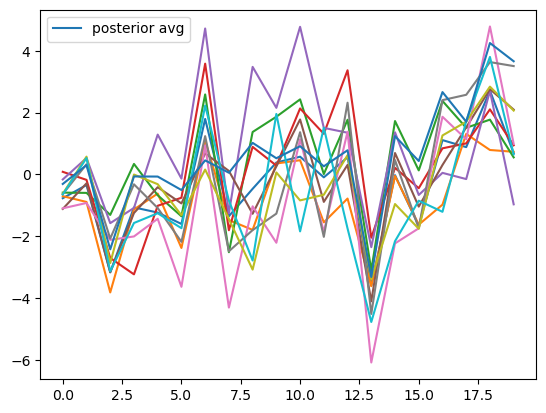

0.9878795933412897
0.988433934323742


In [26]:
# stop = 100
# for i in range(len(_mus_smooth)):
#     plt.plot(_mus_smooth[i,0,:stop])
#     # plt.plot(_mus_smooth[i,0,1,:stop])
#     # plt.show()
# plt.show()

stop = 20
posterior_avg = _mus_smooth.mean(0)
posterior_std = _mus_smooth.std(0)
# prior_avg = z_samps.mean(0)
plt.plot(posterior_avg[0,:stop], label = 'posterior avg')
# plt.plot(mus_smooth[0,:stop], label = 'smoothing')
# plt.plot(prior_avg[0,:stop], label = 'prior avg')
# plt.plot(z_samps[0,0,:stop], label = 'prior sample')
for i in range(10):
    plt.plot(_mus_smooth[i,0,:stop])
plt.legend()
plt.show()
# print R^2 between posterior mean and smoothing
print(r2_score(mus_smooth[0,:], posterior_avg[0,:]))
print(r2_score(mus_smooth[1,:], posterior_avg[1,:]))

In [8]:
# dill.dump(rec_model, open('synthetic_rec.pkl', 'wb'))
dill.dump(rec_model, open('synthetic__small_rec.pkl', 'wb'))
dill.dump(model, open('synthetic__small_gen.pkl', 'wb'))